#**Twitter Bot Detection Dataset and Graph Creation**

In [ ]:
!pip install dgl-cu101 

In [ ]:
import os
import pandas as pd

os.chdir("/content/drive/My Drive/Colab Notebooks/My Project Folder/analytics_capstone")
!pwd

/content/drive/My Drive/Colab Notebooks/My Project Folder/analytics_capstone


In [ ]:
!ls

altmetrics_bot
capstone_datapreprocessing.ipynb
cleaned_crypto_bernardamus_network_edges.csv
crypto_bernardamus_network_edges.csv
crypto_bernardamus_network_nodes.csv
deleted_user_list_idx.csv
dummy_model_twitter.pth
final_cleaned_crypto_bernardamus_network_edges.csv
final_cleaned_crypto_bernardamus_network_nodes.csv
GNNmodel.ipynb
labelled_cleaned_crypto_bernardamus_network_nodes.csv
nodes_test_balanced.csv
nodes_test.csv
nodes_train_balanced.csv
nodes_train.csv
nodes_validate_balanced.csv
nodes_validate.csv
social_honeypot
twitter.bin


###Raw (Imbalanced) Dataset

In [ ]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import numpy as np
import random

class TwitterBotDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='Twitter Bot Dataset')

    def process(self):
        nodes_data = pd.read_csv('final_cleaned_crypto_bernardamus_network_nodes.csv')
        edges_data = pd.read_csv('final_cleaned_crypto_bernardamus_network_edges.csv')
        #create new index for 'Screen Name'
        new_nodes_data = pd.DataFrame(nodes_data["Screen Name"].unique(), columns=["Screen Name"])
        new_nodes_data['Screen Name Id'] = new_nodes_data.index
        #merge new index with original dataframe
        nodes_data = pd.merge(nodes_data, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        #merge new index with edge data
        edges_data = pd.merge(edges_data, new_nodes_data, how='left', left_on='Source', right_on='Screen Name')
        edges_data = pd.merge(edges_data, new_nodes_data, how='left', left_on='Target', right_on='Screen Name')
        #drop unwanted columns
        edges_data.rename(columns={'Screen Name Id_x': 'Source_Id', 'Screen Name Id_y': 'Target_Id'}, inplace=True)
        edges_data.drop('Unnamed: 0', inplace=True, axis=1)
        edges_data.drop('Screen Name_x', inplace=True, axis=1)
        edges_data.drop('Screen Name_y', inplace=True, axis=1)
        #extract features from dataframe and convert to torch tensors note: we should normalize the data too??
        f1 = torch.from_numpy(nodes_data['Age in Years'].to_numpy())
        f2 = torch.from_numpy(nodes_data['# of Followers'].to_numpy())
        f3 = torch.from_numpy(nodes_data['# of Followings'].to_numpy())
        f4 = torch.from_numpy(nodes_data['Follower/Following Ratio'].to_numpy())
        f5 = torch.from_numpy(nodes_data['URL'].to_numpy())
        f6 = torch.from_numpy(nodes_data['Verified'].to_numpy())
        f7 = torch.from_numpy(nodes_data['Number of Tweets'].to_numpy())
        f8 = torch.from_numpy(nodes_data['# of liked Tweets'].to_numpy())
        f9 = torch.from_numpy(nodes_data['# of lists'].to_numpy())
        #stack feature vectors and transpose
        node_features = torch.from_numpy(np.stack((f1,f2,f3,f4,f5,f6,f7,f8,f9)).transpose())
        #convert to float
        node_features = node_features.float()

        node_labels = torch.from_numpy(nodes_data['Bot: 4.0 Threshold'].astype('category').cat.codes.to_numpy())
        node_labels = node_labels.type(torch.LongTensor)
        # edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())  -> no edge features used
        edges_src = torch.from_numpy(edges_data['Source_Id'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['Target_Id'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        # self.graph.edata['weight'] = edge_features  -> no edge features used

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)

        #read train, val, test data and merge with new indexes
        #merge new index with original dataframe
        train = pd.read_csv('nodes_train.csv')
        validate = pd.read_csv('nodes_validate.csv')
        test = pd.read_csv('nodes_test.csv')
        train = pd.merge(train, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        validate = pd.merge(validate, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        test = pd.merge(test, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')

        #create train, val, test masks
        for i in range(len(train)):
          train_mask[train["Screen Name Id"][i]] = True
        for i in range(len(validate)):
          val_mask[validate["Screen Name Id"][i]] = True
        for i in range(len(test)):
          test_mask[test["Screen Name Id"][i]] = True

        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

        #print number of nodes used in train/val/test
        count=0
        for i in range(len(self.graph.ndata['train_mask'])):
          if self.graph.ndata['train_mask'][i] == True:
            count+=1
        print('train nodes count: %d' %count)

        count1=0
        for i in range(len(self.graph.ndata['val_mask'])):
          if self.graph.ndata['val_mask'][i] == True:
            count1+=1
        print('val nodes count: %d' %count1)

        count2=0
        for i in range(len(self.graph.ndata['test_mask'])):
          if self.graph.ndata['test_mask'][i] == True:
            count2+=1
        print('test nodes count: %d' %count2)
        print('total nodes used: %d' %(count+count1+count2))
        print("----------------------------")

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = TwitterBotDataset()
graph = dataset[0]

print(graph)

Using backend: pytorch
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


train nodes count: 2954
val nodes count: 985
test nodes count: 985
total nodes used: 4924
----------------------------
Graph(num_nodes=4924, num_edges=14250,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


###Balanced Dataset

In [ ]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import numpy as np
import random

class TwitterBotDatasetBalanced(DGLDataset):
    def __init__(self):
        super().__init__(name='Twitter Bot Dataset')

    def process(self):
        nodes_data = pd.read_csv('final_cleaned_crypto_bernardamus_network_nodes.csv')
        edges_data = pd.read_csv('final_cleaned_crypto_bernardamus_network_edges.csv')
        #create new index for 'Screen Name'
        new_nodes_data = pd.DataFrame(nodes_data["Screen Name"].unique(), columns=["Screen Name"])
        new_nodes_data['Screen Name Id'] = new_nodes_data.index
        #merge new index with original dataframe
        nodes_data = pd.merge(nodes_data, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        #merge new index with edge data
        edges_data = pd.merge(edges_data, new_nodes_data, how='left', left_on='Source', right_on='Screen Name')
        edges_data = pd.merge(edges_data, new_nodes_data, how='left', left_on='Target', right_on='Screen Name')
        #drop unwanted columns
        edges_data.rename(columns={'Screen Name Id_x': 'Source_Id', 'Screen Name Id_y': 'Target_Id'}, inplace=True)
        edges_data.drop('Unnamed: 0', inplace=True, axis=1)
        edges_data.drop('Screen Name_x', inplace=True, axis=1)
        edges_data.drop('Screen Name_y', inplace=True, axis=1)
        #extract features from dataframe and convert to torch tensors note: we should normalize the data too??
        f1 = torch.from_numpy(nodes_data['Age in Years'].to_numpy())
        f2 = torch.from_numpy(nodes_data['# of Followers'].to_numpy())
        f3 = torch.from_numpy(nodes_data['# of Followings'].to_numpy())
        f4 = torch.from_numpy(nodes_data['Follower/Following Ratio'].to_numpy())
        f5 = torch.from_numpy(nodes_data['URL'].to_numpy())
        f6 = torch.from_numpy(nodes_data['Verified'].to_numpy())
        f7 = torch.from_numpy(nodes_data['Number of Tweets'].to_numpy())
        f8 = torch.from_numpy(nodes_data['# of liked Tweets'].to_numpy())
        f9 = torch.from_numpy(nodes_data['# of lists'].to_numpy())
        #stack feature vectors and transpose
        node_features = torch.from_numpy(np.stack((f1,f2,f3,f4,f5,f6,f7,f8,f9)).transpose())
        #convert to float
        node_features = node_features.float()

        node_labels = torch.from_numpy(nodes_data['Bot: 4.0 Threshold'].astype('category').cat.codes.to_numpy())
        node_labels = node_labels.type(torch.LongTensor)
        # edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())  -> no edge features used
        edges_src = torch.from_numpy(edges_data['Source_Id'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['Target_Id'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        # self.graph.edata['weight'] = edge_features  -> no edge features used

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)

        #read train, val, test data and merge with new indexes
        #merge new index with original dataframe
        train = pd.read_csv('nodes_train_balanced.csv')
        validate = pd.read_csv('nodes_validate_balanced.csv')
        test = pd.read_csv('nodes_test_balanced.csv')
        train = pd.merge(train, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        validate = pd.merge(validate, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')
        test = pd.merge(test, new_nodes_data, how='left', left_on='Screen Name', right_on='Screen Name')

        #create train, val, test masks
        for i in range(len(train)):
          train_mask[train["Screen Name Id"][i]] = True
        for i in range(len(validate)):
          val_mask[validate["Screen Name Id"][i]] = True
        for i in range(len(test)):
          test_mask[test["Screen Name Id"][i]] = True

        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

        #print number of nodes used in train/val/test
        count=0
        for i in range(len(self.graph.ndata['train_mask'])):
          if self.graph.ndata['train_mask'][i] == True:
            count+=1
        print('train nodes count: %d' %count)

        count1=0
        for i in range(len(self.graph.ndata['val_mask'])):
          if self.graph.ndata['val_mask'][i] == True:
            count1+=1
        print('val nodes count: %d' %count1)

        count2=0
        for i in range(len(self.graph.ndata['test_mask'])):
          if self.graph.ndata['test_mask'][i] == True:
            count2+=1
        print('test nodes count: %d' %count2)
        print('total nodes used: %d' %(count+count1+count2))
        print("----------------------------")

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset_balanced = TwitterBotDatasetBalanced()
graph_balanced = dataset_balanced[0]

print(graph_balanced)

train nodes count: 834
val nodes count: 279
test nodes count: 279
total nodes used: 1392
----------------------------
Graph(num_nodes=4924, num_edges=14250,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [ ]:
# import networkx as nx
# # Since the actual graph is undirected, we convert it for visualization
# # purpose.
# nx_G = graph.to_networkx().to_undirected()
# # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

#**GCN Implementation**

We first define the message and reduce function as usual. Since the aggregation on a node u only involves summing over the neighbors’ representations hv, we can simply use builtin functions:

In [ ]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

We then proceed to define the GCNLayer module. A GCNLayer essentially performs message passing on all the nodes then applies a fully-connected layer.

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

The forward function is essentially the same as any other commonly seen NNs model in PyTorch. We can initialize GCN like any nn.Module. For example, let’s define a simple neural network consisting of two GCN layers. Suppose we are training the classifier for the Twitter dataset (the input feature size is 9 and the number of classes is 2). The last GCN layer computes node embeddings, so the last layer in general does not apply activation.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #9 input features, 100 hidden vector size, 2 output classes
        self.layer1 = GCNLayer(9, 100)
        self.layer2 = GCNLayer(100, 2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

When a model is trained, we can use the following method to evaluate the performance of the model on the test dataset:

In [ ]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        TP = 0.00001
        TN = 0.00001 
        FP = 0.00001
        FN = 0.00001
        for i in range(len(indices)):
          if indices[i] == 1 and indices[i] == labels[i]:
            TP+=1
          elif indices[i] == 0 and indices[i] == labels[i]:
            TN+=1
          elif indices[i] == 1 and indices[i] != labels[i]:
            FP+=1
          else:
            FN+=1
        precision = float(TP/(TP+FP))
        recall = float(TP/(TP+FN))
        f1 = TP/(TP+0.5*(FP+FN))
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels)
        return acc, precision, recall, f1, indices, labels

##Training Model - Imbalanced Dataset


We then train the network as follows:

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | F1 0.2435 | Train Acc 0.1984 | Validation Acc 0.2152 | Precision 0.1403 | Recall 0.9203 | Time(s) nan | Loss 18892.5547
Epoch 00200 | F1 0.0741 | Train Acc 0.8561 | Validation Acc 0.8406 | Precision 0.3778 | Recall 0.0411 | Time(s) 0.0133 | Loss 1523.6584
Epoch 00400 | F1 0.0784 | Train Acc 0.8568 | Validation Acc 0.8365 | Precision 0.4000 | Recall 0.0435 | Time(s) 0.0133 | Loss 2329.1396
Epoch 00600 | F1 0.0736 | Train Acc 0.8551 | Validation Acc 0.8365 | Precision 0.3542 | Recall 0.0411 | Time(s) 0.0133 | Loss 1090.7095
Epoch 00800 | F1 0.0545 | Train Acc 0.8592 | Validation Acc 0.8467 | Precision 0.4615 | Recall 0.0290 | Time(s) 0.0132 | Loss 409.5760
Epoch 01000 | F1 0.0662 | Train Acc 0.8568 | Validation Acc 0.8376 | Precision 0.3846 | Recall 0.0362 | Time(s) 0.0132 | Loss 446.2859
Epoch 01200 | F1 0.0952 | Train Acc 0.8521 | Validation Acc 0.8294 | Precision 0.3333 | Recall 0.0556 | Time(s) 0.0131 | Loss 115.2723
Epoch 01400 | F1 0.0830 | Train Acc 0.8578 | Validati

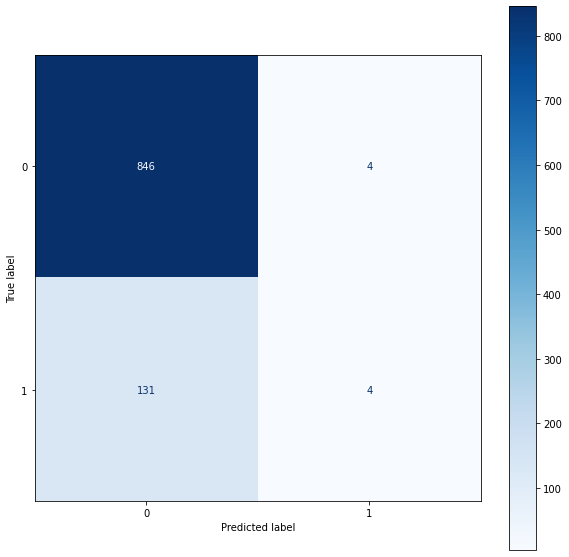

In [ ]:
import networkx as nx
import time
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

GCNmodel = Net()

#load data from graph
g = graph
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

optimizer = th.optim.Adam(GCNmodel.parameters(), lr=1e-2)
dur = []
gcn_train_acc = []
gcn_test_acc = []
gcn_train_loss = []
for epoch in range(3000):
    if epoch >=3:
        t0 = time.time()

    GCNmodel.train()
    logits = GCNmodel(g, features)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    acc, precision, recall, f1, indices, y_label = evaluate(GCNmodel, g, features, labels, train_mask)
    acc1, precision1, recall1, f11, indices1, y_label1 = evaluate(GCNmodel, g, features, labels, val_mask)

    if epoch % 200 == 0:
      gcn_train_acc.append(acc)
      gcn_test_acc.append(acc1)
      gcn_train_loss.append(loss)
      print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

    # if epoch % 200 == 0:
    #       print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

acc2, precision2, recall2, f12, indices2, y_label2 = evaluate(GCNmodel, g, features, labels, test_mask)
print("---------------------------------------------------------------------------------------------------------------------")
print("              F1 {:.4f} | Test Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(f12, acc2, precision2, recall2, np.mean(dur), loss.item()))
print("---------------------------------------------------------------------------------------------------------------------")

cm = confusion_matrix(y_label2, indices2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)

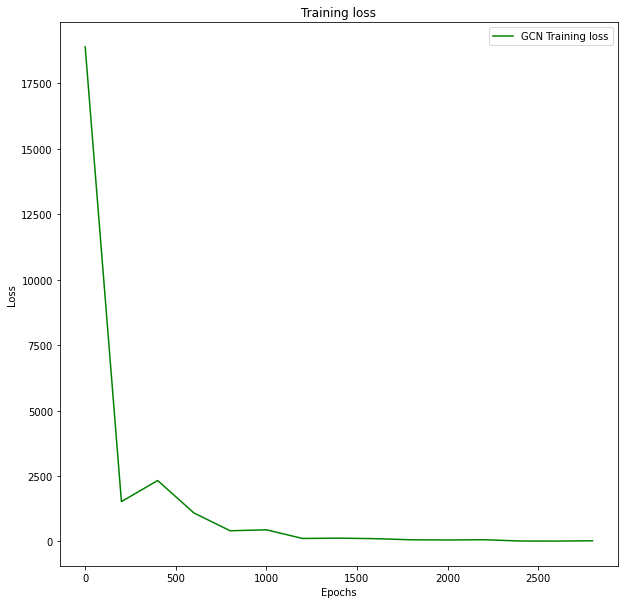

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gcn_train_loss, 'g', label='GCN Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

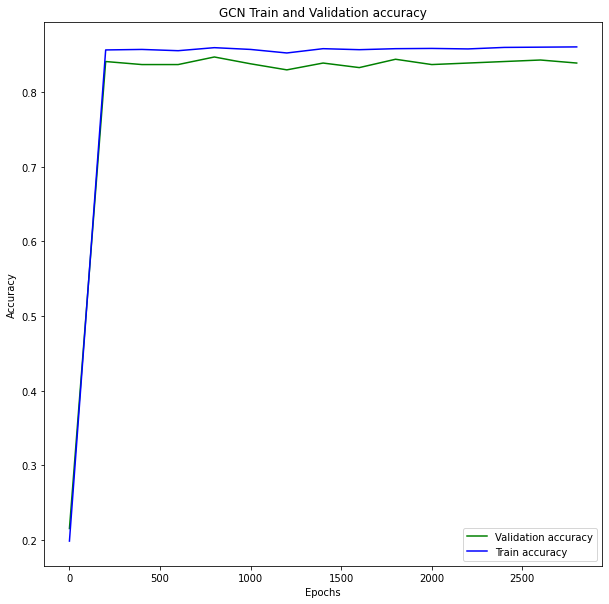

In [ ]:
epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gcn_test_acc, 'g', label='Validation accuracy')
plt.plot(epochs, gcn_train_acc, 'b', label='Train accuracy')
plt.title('GCN Train and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Training Model - Balanced Dataset


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | F1 0.6222 | Train Acc 0.5312 | Validation Acc 0.6022 | Precision 0.5079 | Recall 0.8030 | Time(s) nan | Loss 210001.6250
Epoch 00200 | F1 0.1322 | Train Acc 0.5276 | Validation Acc 0.4444 | Precision 0.5660 | Recall 0.0748 | Time(s) 0.0121 | Loss 221.5612
Epoch 00400 | F1 0.1174 | Train Acc 0.5312 | Validation Acc 0.4444 | Precision 0.6190 | Recall 0.0648 | Time(s) 0.0120 | Loss 58.9739
Epoch 00600 | F1 0.3200 | Train Acc 0.4904 | Validation Acc 0.4265 | Precision 0.4464 | Recall 0.2494 | Time(s) 0.0120 | Loss 213.0390
Epoch 00800 | F1 0.2586 | Train Acc 0.5324 | Validation Acc 0.4337 | Precision 0.5440 | Recall 0.1696 | Time(s) 0.0119 | Loss 63.2548
Epoch 01000 | F1 0.1213 | Train Acc 0.5312 | Validation Acc 0.4337 | Precision 0.6136 | Recall 0.0673 | Time(s) 0.0120 | Loss 1597.0303
Epoch 01200 | F1 0.1300 | Train Acc 0.5348 | Validation Acc 0.4409 | Precision 0.6444 | Recall 0.0723 | Time(s) 0.0120 | Loss 13.7588
Epoch 01400 | F1 0.1361 | Train Acc 0.5432 | Validation A

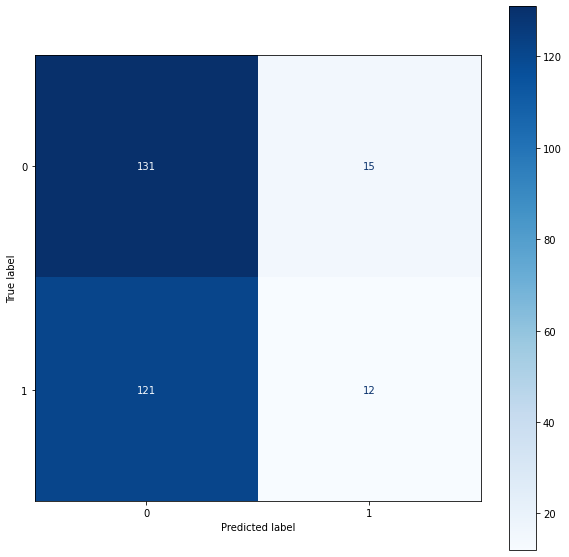

In [ ]:
import networkx as nx
import time
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

GCNmodel_bal = Net()

#load data from graph
g = graph_balanced
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

optimizer = th.optim.Adam(GCNmodel_bal.parameters(), lr=1e-2)
dur = []
gcn_train_acc = []
gcn_test_acc = []
gcn_train_loss = []
for epoch in range(3000):
    if epoch >=3:
        t0 = time.time()

    GCNmodel_bal.train()
    logits = GCNmodel_bal(g, features)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    acc, precision, recall, f1, indices, y_label = evaluate(GCNmodel_bal, g, features, labels, train_mask)
    acc1, precision1, recall1, f11, indices1, y_label1 = evaluate(GCNmodel_bal, g, features, labels, val_mask)

    if epoch % 200 == 0:
      gcn_train_acc.append(acc)
      gcn_test_acc.append(acc1)
      gcn_train_loss.append(loss)
      print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

    # if epoch % 200 == 0:
    #       print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

acc2, precision2, recall2, f12, indices2, y_label2 = evaluate(GCNmodel_bal, g, features, labels, test_mask)
print("---------------------------------------------------------------------------------------------------------------------")
print("              F1 {:.4f} | Test Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(f12, acc2, precision2, recall2, np.mean(dur), loss.item()))
print("---------------------------------------------------------------------------------------------------------------------")

cm = confusion_matrix(y_label2, indices2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)

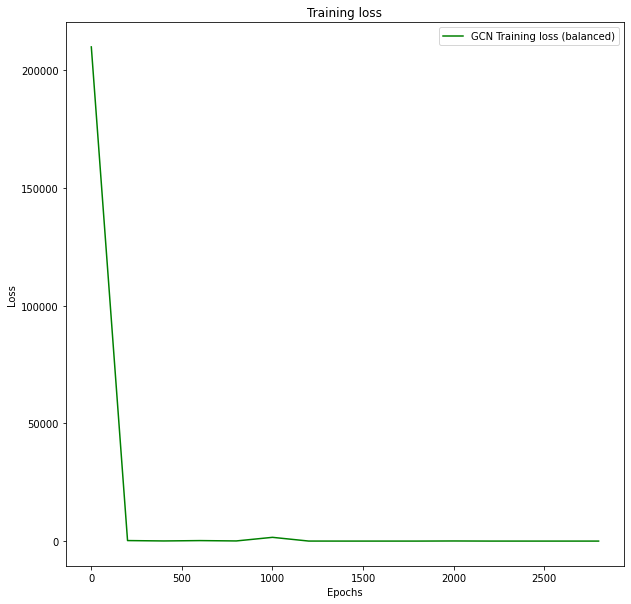

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gcn_train_loss, 'g', label='GCN Training loss (balanced)')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

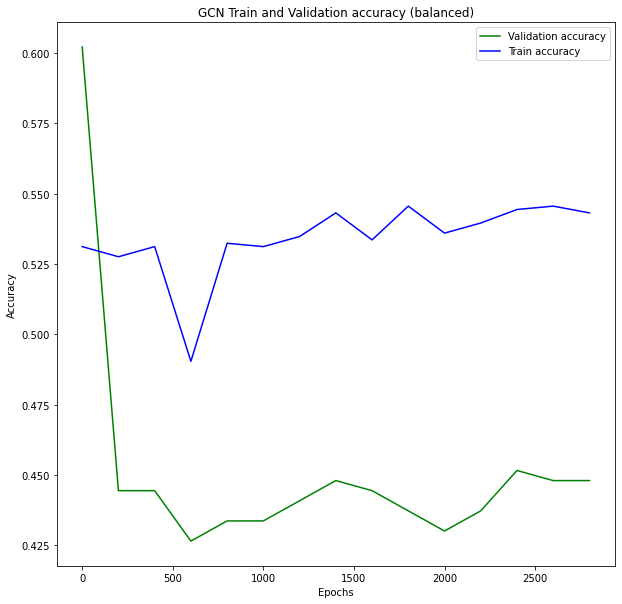

In [ ]:
epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gcn_test_acc, 'g', label='Validation accuracy')
plt.plot(epochs, gcn_train_acc, 'b', label='Train accuracy')
plt.title('GCN Train and Validation accuracy (balanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#**GraphSAGE Implementation**

In [ ]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import time

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        TP = 0
        TN = 0 
        FP = 0
        FN = 0
        for i in range(len(indices)):
          if indices[i] == 1 and indices[i] == labels[i]:
            TP+=1
          elif indices[i] == 0 and indices[i] == labels[i]:
            TN+=1
          elif indices[i] == 1 and indices[i] != labels[i]:
            FP+=1
          else:
            FN+=1
        precision = float(TP/(TP+FP))
        recall = float(TP/(TP+FN))
        f1 = TP/(TP+0.5*(FP+FN))
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels)
        return acc, precision, recall, f1, indices, labels

##Training Model - Imbalanced Dataset


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | F1 0.1238 | Train Acc 0.7173 | Validation Acc 0.6873 | Precision 0.1095 | Recall 0.1425 | Time(s) nan | Loss 27139.2480
Epoch 00200 | F1 0.2062 | Train Acc 0.8253 | Validation Acc 0.8000 | Precision 0.2839 | Recall 0.1618 | Time(s) 0.1088 | Loss 177.3827
Epoch 00400 | F1 0.2772 | Train Acc 0.7952 | Validation Acc 0.7655 | Precision 0.2742 | Recall 0.2802 | Time(s) 0.1075 | Loss 132.2922
Epoch 00600 | F1 0.2893 | Train Acc 0.8470 | Validation Acc 0.8305 | Precision 0.4144 | Recall 0.2222 | Time(s) 0.1069 | Loss 141.9423
Epoch 00800 | F1 0.4203 | Train Acc 0.8450 | Validation Acc 0.8335 | Precision 0.4415 | Recall 0.4010 | Time(s) 0.1061 | Loss 333.1118
Epoch 01000 | F1 0.4415 | Train Acc 0.8724 | Validation Acc 0.8528 | Precision 0.5709 | Recall 0.3599 | Time(s) 0.1057 | Loss 231.1001
Epoch 01200 | F1 0.4669 | Train Acc 0.8663 | Validation Acc 0.8477 | Precision 0.5291 | Recall 0.4179 | Time(s) 0.1053 | Loss 72.5148
Epoch 01400 | F1 0.5156 | Train Acc 0.8791 | Validation A

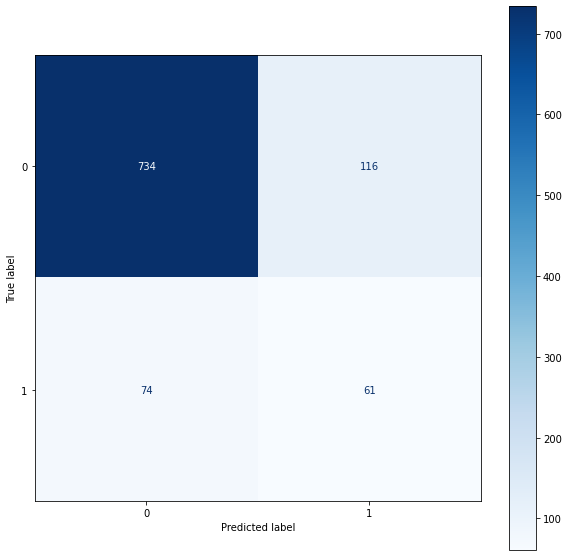

In [ ]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

GraphSAGEmodel = SAGE(in_feats=9, hid_feats=100, out_feats=2)
opt = torch.optim.Adam(GraphSAGEmodel.parameters())

#load data from graph
g = graph
node_features = g.ndata['feat']
node_labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

dur = []
gs_train_acc = []
gs_test_acc = []
gs_train_loss = []
for epoch in range(3000):
    if epoch >=3:
        t0 = time.time()
    GraphSAGEmodel.train()
    # forward propagation by using all nodes
    logits = GraphSAGEmodel(g, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # compute train accuracy
    acc, precision, recall, f1, indices, y_label = evaluate(GraphSAGEmodel, g, node_features, node_labels, train_mask)
    # compute validation accuracy
    acc1, precision1, recall1, f11, indices1, y_label1 = evaluate(GraphSAGEmodel, g, node_features, node_labels, val_mask)

    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    if epoch % 200 == 0:
      gs_train_acc.append(acc)
      gs_test_acc.append(acc1)
      gs_train_loss.append(loss)
      print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

acc2, precision2, recall2, f12, indices2, y_label2 = evaluate(GraphSAGEmodel, g, node_features, node_labels, test_mask)
print("---------------------------------------------------------------------------------------------------------------------")
print("              F1 {:.4f} | Test Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(f12, acc2, precision2, recall2, np.mean(dur), loss.item()))
print("---------------------------------------------------------------------------------------------------------------------")

cm = confusion_matrix(y_label2, indices2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)

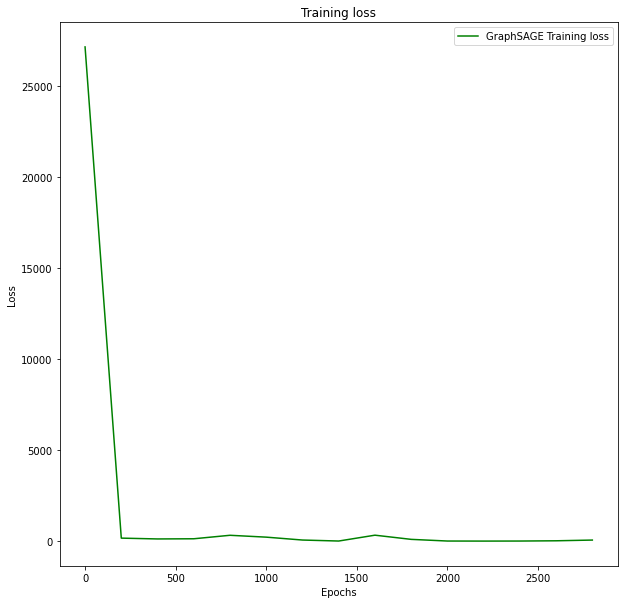

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gs_train_loss, 'g', label='GraphSAGE Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

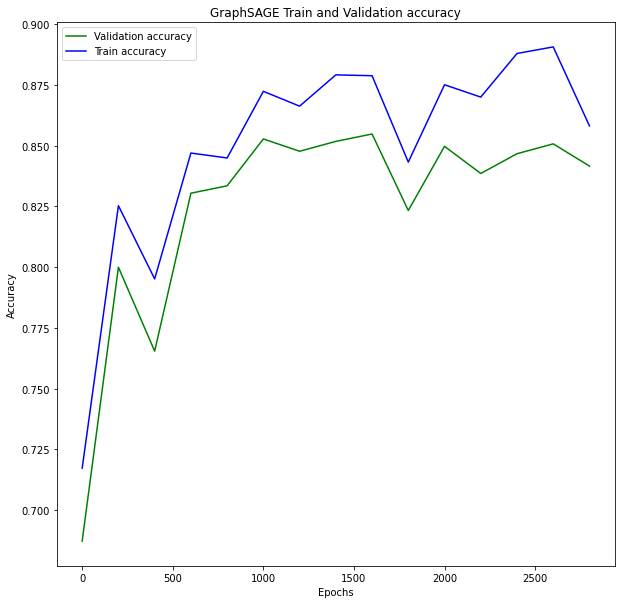

In [ ]:
 epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gs_test_acc, 'g', label='Validation accuracy')
plt.plot(epochs, gs_train_acc, 'b', label='Train accuracy')
plt.title('GraphSAGE Train and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Training Model - Balanced Dataset


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | F1 0.6594 | Train Acc 0.5480 | Validation Acc 0.6416 | Precision 0.5170 | Recall 0.9102 | Time(s) nan | Loss 23008.4082
Epoch 00200 | F1 0.6675 | Train Acc 0.6978 | Validation Acc 0.6093 | Precision 0.7087 | Recall 0.6309 | Time(s) 0.0501 | Loss 78.3592
Epoch 00400 | F1 0.7158 | Train Acc 0.7410 | Validation Acc 0.6129 | Precision 0.7577 | Recall 0.6783 | Time(s) 0.0489 | Loss 111.7233
Epoch 00600 | F1 0.7129 | Train Acc 0.7518 | Validation Acc 0.6237 | Precision 0.8031 | Recall 0.6409 | Time(s) 0.0485 | Loss 51.7798
Epoch 00800 | F1 0.7344 | Train Acc 0.7146 | Validation Acc 0.6165 | Precision 0.6646 | Recall 0.8204 | Time(s) 0.0486 | Loss 112.5435
Epoch 01000 | F1 0.7577 | Train Acc 0.7830 | Validation Acc 0.6093 | Precision 0.8179 | Recall 0.7057 | Time(s) 0.0483 | Loss 44.3469
Epoch 01200 | F1 0.7529 | Train Acc 0.7182 | Validation Acc 0.6237 | Precision 0.6509 | Recall 0.8928 | Time(s) 0.0481 | Loss 225.1378
Epoch 01400 | F1 0.7878 | Train Acc 0.7746 | Validation Acc

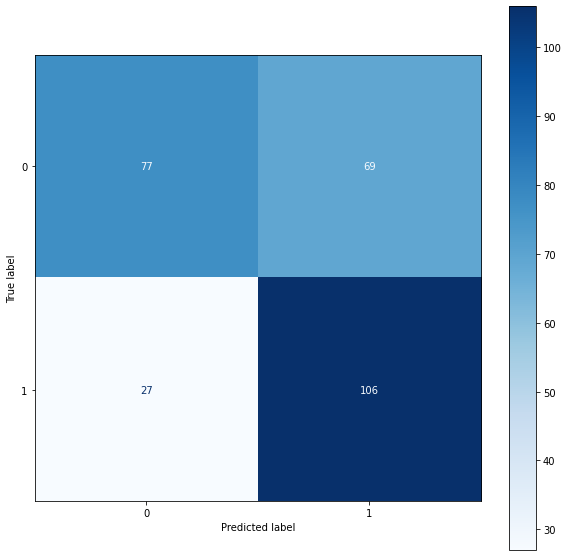

In [ ]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

GraphSAGEmodel_bal = SAGE(in_feats=9, hid_feats=100, out_feats=2)
opt = torch.optim.Adam(GraphSAGEmodel_bal.parameters())

#load data from graph
g = graph_balanced
node_features = g.ndata['feat']
node_labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

dur = []
gs_train_acc = []
gs_test_acc = []
gs_train_loss = []
for epoch in range(3000):
    if epoch >=3:
        t0 = time.time()
    GraphSAGEmodel_bal.train()
    # forward propagation by using all nodes
    logits = GraphSAGEmodel_bal(g, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # compute train accuracy
    acc, precision, recall, f1, indices, y_label = evaluate(GraphSAGEmodel_bal, g, node_features, node_labels, train_mask)
    # compute validation accuracy
    acc1, precision1, recall1, f11, indices1, y_label1 = evaluate(GraphSAGEmodel_bal, g, node_features, node_labels, val_mask)

    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    if epoch % 200 == 0:
      gs_train_acc.append(acc)
      gs_test_acc.append(acc1)
      gs_train_loss.append(loss)
      print("Epoch {:05d} | F1 {:.4f} | Train Acc {:.4f} | Validation Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(epoch, f1, acc, acc1, precision, recall, np.mean(dur), loss.item()))

acc2, precision2, recall2, f12, indices2, y_label2 = evaluate(GraphSAGEmodel_bal, g, node_features, node_labels, test_mask)
print("---------------------------------------------------------------------------------------------------------------------")
print("              F1 {:.4f} | Test Acc {:.4f} | Precision {:.4f} | Recall {:.4f} | Time(s) {:.4f} | Loss {:.4f}".format(f12, acc2, precision2, recall2, np.mean(dur), loss.item()))
print("---------------------------------------------------------------------------------------------------------------------")

cm = confusion_matrix(y_label2, indices2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d',ax=ax)

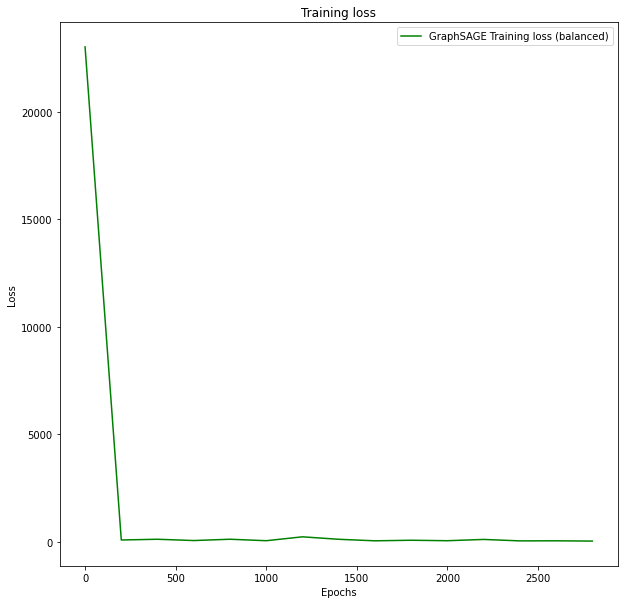

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gs_train_loss, 'g', label='GraphSAGE Training loss (balanced)')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

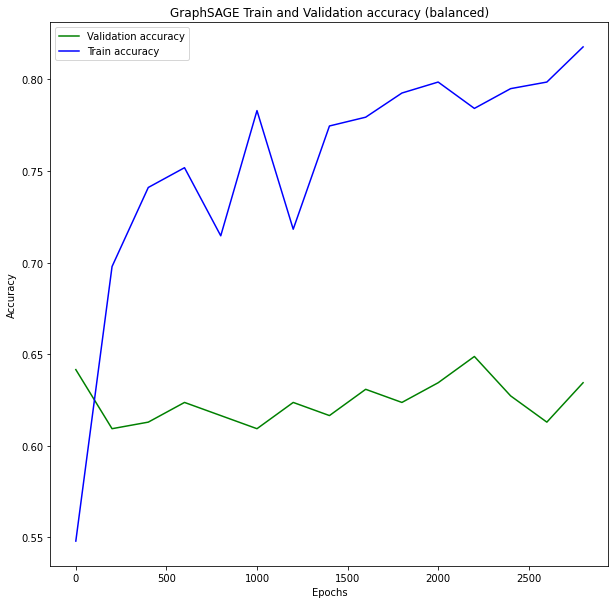

In [ ]:
epochs = range(0,3000,200)
plt.figure(figsize=(10, 10))
plt.plot(epochs, gs_test_acc, 'g', label='Validation accuracy')
plt.plot(epochs, gs_train_acc, 'b', label='Train accuracy')
plt.title('GraphSAGE Train and Validation accuracy (balanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn


class dummy_layer(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(dummy_layer, self).__init__()
        self.layer = nn.Linear(in_dim * 2, out_dim, bias=True)

    def forward(self, graph, n_feats, e_weights=None):
        graph.ndata['h'] = n_feats

        if e_weights == None:
            graph.update_all(fn.copy_u('h', 'm'), fn.mean('m', 'h'))
        else:
            graph.edata['ew'] = e_weights
            graph.update_all(fn.u_mul_e('h', 'ew', 'm'), fn.mean('m', 'h'))

        graph.ndata['h'] = self.layer(th.cat([graph.ndata['h'], n_feats], dim=-1))

        output = graph.ndata['h']
        return output


class dummy_gnn_model(nn.Module):

    """
    A dummy gnn model, which is same as graph sage, but could adopt edge mask in forward
    """
    def __init__(self,
                 in_dim,
                 hid_dim,
                 out_dim):
        super(dummy_gnn_model, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.in_layer = dummy_layer(self.in_dim, self.hid_dim)
        self.hid_layer = dummy_layer(self.hid_dim, self.hid_dim)
        self.out_layer = dummy_layer(self.hid_dim, self.out_dim)

    def forward(self, graph, n_feat, edge_weights=None):

        h = self.in_layer(graph, n_feat, edge_weights)
        h = F.relu(h)
        h = self.hid_layer(graph, h, edge_weights)
        h = F.relu(h)
        h = self.out_layer(graph, h, edge_weights)

        return h

In [ ]:
# The training codes of the dummy model


import os
import argparse
import dgl

import torch as th
import torch.nn as nn

from dgl import save_graphs
# from models import dummy_gnn_model
# from gengraph import gen_syn1, gen_syn2, gen_syn3, gen_syn4, gen_syn5
import numpy as np

# def main(args):
#     # load dataset
#     if args.dataset == 'syn1':
#         g, labels, name = gen_syn1()
#     elif args.dataset == 'syn2':
#         g, labels, name = gen_syn2()
#     elif args.dataset == 'syn3':
#         g, labels, name = gen_syn3()
#     elif args.dataset == 'syn4':
#         g, labels, name = gen_syn4()
#     elif args.dataset == 'syn5':
#         g, labels, name = gen_syn5()
#     else:
#         raise NotImplementedError


#load data from graph
g = graph
node_features = g.ndata['feat']
node_labels = g.ndata['label']
train_mask = g.ndata['train_mask']
# val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

#Transform to dgl graph. 
# graph = dgl.from_networkx(g) 
# labels = th.tensor(labels, dtype=th.long)
# graph.ndata['label'] = labels
# graph.ndata['feat'] = th.randn(graph.number_of_nodes(), args.feat_dim)
hidden_dim = 100
hid_dim = th.tensor(hidden_dim, dtype=th.long)
label_dict = {'hid_dim':hid_dim}
lr=0.001
wd=0.0
feat_dim=9


# save graph for later use
save_graphs(filename='./'+'twitter'+'.bin', g_list=[g], labels=label_dict)

num_classes = max(g.ndata['label']).item() + 1
n_feats = g.ndata['feat']

#create model
dummy_model = dummy_gnn_model(feat_dim, hidden_dim, num_classes)
loss_fn = nn.CrossEntropyLoss()
optim = th.optim.Adam(dummy_model.parameters(), lr=lr, weight_decay=wd)

# train and output
for epoch in range(200):

    dummy_model.train()

    logits = dummy_model(graph, n_feats)
    loss = loss_fn(logits, node_labels)
    acc = th.sum(logits.argmax(dim=1) == node_labels).item() / len(node_labels)
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    print('In Epoch: {:03d}; Acc: {:.4f}; Loss: {:.6f}'.format(epoch, acc, loss.item()))

# save model
model_stat_dict = dummy_model.state_dict()
model_path = os.path.join('./', 'dummy_model_{}.pth'.format('twitter'))
th.save(model_stat_dict, model_path)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Dummy model training')
#     parser.add_argument('--dataset', type=str, default='syn1', help='The dataset used for training the model.')
#     parser.add_argument('--feat_dim', type=int, default=10, help='The feature dimension.')
#     parser.add_argument('--hidden_dim', type=int, default=40, help='The hidden dimension.')
#     parser.add_argument('--epochs', type=int, default=500, help='The number of epochs.')
#     parser.add_argument('--lr', type=float, default=0.001, help='The learning rate.')
#     parser.add_argument('--wd', type=float, default=0.0, help='Weight decay.')

#     args = parser.parse_args()
#     print(args)

#     main(args)

In Epoch: 000; Acc: 0.7331; Loss: 228.790421
In Epoch: 001; Acc: 0.8509; Loss: 390.490051
In Epoch: 002; Acc: 0.7465; Loss: 285.831512
In Epoch: 003; Acc: 0.5067; Loss: 420.420959
In Epoch: 004; Acc: 0.8069; Loss: 153.535202
In Epoch: 005; Acc: 0.8578; Loss: 279.206696
In Epoch: 006; Acc: 0.8576; Loss: 344.951874
In Epoch: 007; Acc: 0.8540; Loss: 387.763824
In Epoch: 008; Acc: 0.8146; Loss: 416.306702
In Epoch: 009; Acc: 0.7931; Loss: 420.523041
In Epoch: 010; Acc: 0.7847; Loss: 397.812805
In Epoch: 011; Acc: 0.7868; Loss: 364.271118
In Epoch: 012; Acc: 0.7894; Loss: 332.885284
In Epoch: 013; Acc: 0.7933; Loss: 314.401184
In Epoch: 014; Acc: 0.8325; Loss: 275.774811
In Epoch: 015; Acc: 0.8637; Loss: 243.204285
In Epoch: 016; Acc: 0.8591; Loss: 198.619598
In Epoch: 017; Acc: 0.8294; Loss: 143.717667
In Epoch: 018; Acc: 0.7961; Loss: 87.706802
In Epoch: 019; Acc: 0.7644; Loss: 42.464878
In Epoch: 020; Acc: 0.6359; Loss: 445.938568
In Epoch: 021; Acc: 0.7774; Loss: 86.626633
In Epoch: 022

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import math


class NodeExplainerModule(nn.Module):
    """
    A Pytorch module for explaining a node's prediction based on its computational graph and node features.
    Use two masks: One mask on edges, and another on nodes' features.
    So far due to the limit of DGL on edge mask operation, this explainer need the to-be-explained models to
    accept an additional input argument, edge mask, and apply this mask in their inner message parse operation.
    This is current walk_around to use edge masks.
    """

    # Class inner variables
    loss_coef = {
        "g_size": 0.05,
        "feat_size": 1.0,
        "g_ent": 0.1,
        "feat_ent": 0.1
    }

    def __init__(self,
                 model,
                 num_edges,
                 node_feat_dim,
                 activation='sigmoid',
                 agg_fn='sum',
                 mask_bias=False):
        super(NodeExplainerModule, self).__init__()
        self.model = model
        self.model.eval()
        self.num_edges = num_edges
        self.node_feat_dim = node_feat_dim
        self.activation = activation
        self.agg_fn=agg_fn
        self.mask_bias = mask_bias

        # Initialize parameters on masks
        self.edge_mask, self.edge_mask_bias = self.create_edge_mask(self.num_edges)
        self.node_feat_mask = self.create_node_feat_mask(self.node_feat_dim)


    def create_edge_mask(self, num_edges, init_strategy='normal', const=1.):
        """
        Based on the number of nodes in the computational graph, create a learnable mask of edges.
        To adopt to DGL, change this mask from N*N adjacency matrix to the No. of edges
        Parameters
        ----------
        num_edges: Integer N, specify the number of edges.
        init_strategy: String, specify the parameter initialization method
        const: Float, a value for constant initialization
        Returns
        -------
        mask and mask bias: Tensor, all in shape of N*1
        """
        mask = nn.Parameter(th.Tensor(num_edges, 1))

        if init_strategy == 'normal':
            std = nn.init.calculate_gain("relu") * math.sqrt(
                1.0 / num_edges
            )
            with th.no_grad():
                mask.normal_(1.0, std)
        elif init_strategy == "const":
            nn.init.constant_(mask, const)

        if self.mask_bias:
            mask_bias = nn.Parameter(th.Tensor(num_edges, 1))
            nn.init.constant_(mask_bias, 0.0)
        else:
            mask_bias = None

        return mask, mask_bias


    def create_node_feat_mask(self, node_feat_dim, init_strategy="normal"):
        """
        Based on the dimensions of node feature in the computational graph, create a learnable mask of features.
        Parameters
        ----------
        node_feat_dim: Integer N, dimensions of node feature
        init_strategy: String, specify the parameter initialization method
        Returns
        -------
        mask: Tensor, in shape of N
        """
        mask = nn.Parameter(th.Tensor(node_feat_dim))

        if init_strategy == "normal":
            std = 0.1
            with th.no_grad():
                mask.normal_(1.0, std)
        elif init_strategy == "constant":
            with th.no_grad():
                nn.init.constant_(mask, 0.0)
        return mask


    def forward(self, graph, n_feats):
        """
        Calculate prediction results after masking input of the given model.
        Parameters
        ----------
        graph: DGLGraph, Should be a sub_graph of the target node to be explained.
        n_idx: Tensor, an integer, index of the node to be explained.
        Returns
        -------
        new_logits: Tensor, in shape of N * Num_Classes
        """

        # Step 1: Mask node feature with the inner feature mask
        new_n_feats = n_feats * self.node_feat_mask.sigmoid()
        edge_mask = self.edge_mask.sigmoid()

        # Step 2: Add compute logits after mask node features and edges
        new_logits = self.model(graph, new_n_feats, edge_mask)

        return new_logits


    def _loss(self, pred_logits, pred_label):
        """
        Compute the losses of this explainer, which include 6 parts in author's codes:
        1. The prediction loss between predict logits before and after node and edge masking;
        2. Loss of edge mask itself, which tries to put the mask value to either 0 or 1;
        3. Loss of node feature mask itself,  which tries to put the mask value to either 0 or 1;
        4. L2 loss of edge mask weights, but in sum not in mean;
        5. L2 loss of node feature mask weights, which is NOT used in the author's codes;
        6. Laplacian loss of the adj matrix.
        In the PyG implementation, there are 5 types of losses:
        1. The prediction loss between logits before and after node and edge masking;
        2. Sum loss of edge mask weights;
        3. Loss of edge mask entropy, which tries to put the mask value to either 0 or 1;
        4. Sum loss of node feature mask weights;
        5. Loss of node feature mask entropy, which tries to put the mask value to either 0 or 1;
        Parameters
        ----------
        pred_logits：Tensor, N-dim logits output of model
        pred_label: Tensor, N-dim one-hot label of the label
        Returns
        -------
        loss: Scalar, the overall loss of this explainer.
        """
        # 1. prediction loss
        log_logit = - F.log_softmax(pred_logits, dim=-1)
        pred_loss = th.sum(log_logit * pred_label)

        # 2. edge mask loss
        if self.activation == 'sigmoid':
            edge_mask = th.sigmoid(self.edge_mask)
        elif self.activation == 'relu':
            edge_mask = F.relu(self.edge_mask)
        else:
            raise ValueError()
        edge_mask_loss = self.loss_coef['g_size'] * th.sum(edge_mask)

        # 3. edge mask entropy loss
        edge_ent = -edge_mask * \
                   th.log(edge_mask + 1e-8) - \
                   (1 - edge_mask) * \
                   th.log(1 - edge_mask + 1e-8)
        edge_ent_loss = self.loss_coef['g_ent'] * th.mean(edge_ent)

        # 4. node feature mask loss
        if self.activation == 'sigmoid':
            node_feat_mask = th.sigmoid(self.node_feat_mask)
        elif self.activation == 'relu':
            node_feat_mask = F.relu(self.node_feat_mask)
        else:
            raise ValueError()
        node_feat_mask_loss = self.loss_coef['feat_size'] * th.sum(node_feat_mask)

        # 5. node feature mask entry loss
        node_feat_ent = -node_feat_mask * \
                        th.log(node_feat_mask + 1e-8) - \
                        (1 - node_feat_mask) * \
                        th.log( 1 - node_feat_mask + 1e-8)
        node_feat_ent_loss = self.loss_coef['feat_ent'] * th.mean(node_feat_ent)

        total_loss = pred_loss + edge_mask_loss + edge_ent_loss + node_feat_mask_loss + node_feat_ent_loss

        return total_loss

In [ ]:
# Utility file for graph queries

import tkinter
import matplotlib
# matplotlib.use('TkAgg')

import networkx as nx
import matplotlib.pylab as plt
import torch as th
import dgl
from dgl.sampling import sample_neighbors

def extract_subgraph(graph, seed_nodes, hops=2):
    """
    For the explainability, extract the subgraph of a seed node with the hops specified.
    Parameters
    ----------
    graph:      DGLGraph, the full graph to extract from. This time, assume it is a homograph
    seed_nodes:  Tensor, index of a node in the graph
    hops:       Integer, the number of hops to extract
    Returns
    -------
    sub_graph: DGLGraph, a sub graph
    origin_nodes: List, list of node ids in the origin graph, sorted from small to large, whose order is the new id. e.g
               [2, 51, 53, 79] means in the new sug_graph, their new node id is [0,1,2,3], the mapping is 2<>0, 51<>1, 53<>2,
               and 79 <> 3.
    new_seed_node: Scalar, the node index of seed_nodes
    """
    seeds=seed_nodes
    for i in range(hops):
        i_hop = sample_neighbors(graph, seeds, -1)
        seeds = th.cat([seeds, i_hop.edges()[0]])
    
    ori_src, ori_dst = i_hop.edges()
    edge_all = th.cat([ori_src, ori_dst])
    origin_nodes, new_edges_all = th.unique(edge_all, return_inverse=True)

    n = int(new_edges_all.shape[0] / 2)
    new_src = new_edges_all[:n]
    new_dst = new_edges_all[n:]

    sub_graph = dgl.DGLGraph((new_src, new_dst))
    new_seed_node = th.nonzero(origin_nodes==seed_nodes, as_tuple=True)[0][0]

    return sub_graph, origin_nodes, new_seed_node


def visualize_sub_graph(sub_graph, edge_weights=None, origin_nodes=None, center_node=None):
    """
    Use networkx to visualize the sub_graph and,
    if edge weights are given, set edges with different fading of blue.
    Parameters
    ----------
    sub_graph: DGLGraph, the sub_graph to be visualized.
    edge_weights: Tensor, the same number of edges. Values are (0,1), default is None
    origin_nodes: List, list of node ids that will be used to replace the node ids in the subgraph in visualization
    center_node: Tensor, the node id in origin node list to be highlighted with different color
    Returns
    show the sub_graph
    -------
    """
    # Extract original idx and map to the new networkx graph
    # Convert to networkx graph
    g = dgl.to_networkx(sub_graph)
    nx_edges = g.edges(data=True)

    if not (origin_nodes is None):
        n_mapping = {new_id: old_id for new_id, old_id in enumerate(origin_nodes.tolist())}
        g = nx.relabel_nodes(g, mapping=n_mapping)

    pos = nx.spring_layout(g)

    if edge_weights is None:
        options = {"node_size": 1000,
                   "alpha": 0.9,
                   "font_size":24,
                   "width": 4,
                   }
    else:

        ec = [edge_weights[e[2]['id']][0] for e in nx_edges]
        options = {"node_size": 1000,
                   "alpha": 0.3,
                   "font_size": 12,
                   "edge_color": ec,
                   "width": 4,
                   "edge_cmap": plt.cm.Reds,
                   "edge_vmin": 0,
                   "edge_vmax": 1,
                   "connectionstyle":"arc3,rad=0.1"}

    nx.draw(g, pos, with_labels=True, node_color='b', **options)
    if not (center_node is None):
        nx.draw(g, pos, nodelist=center_node.tolist(), with_labels=True, node_color='r', **options)

    plt.show()

In [ ]:
!ls

altmetrics_bot
capstone_datapreprocessing.ipynb
cleaned_crypto_bernardamus_network_edges.csv
crypto_bernardamus_network_edges.csv
crypto_bernardamus_network_nodes.csv
deleted_user_list_idx.csv
dummy_model_twitter.pth
final_cleaned_crypto_bernardamus_network_edges.csv
final_cleaned_crypto_bernardamus_network_nodes.csv
GNNmodel.ipynb
labelled_cleaned_crypto_bernardamus_network_nodes.csv
nodes_test_balanced.csv
nodes_test.csv
nodes_train_balanced.csv
nodes_train.csv
nodes_validate_balanced.csv
nodes_validate.csv
social_honeypot
twitter.bin


In [ ]:
seeds_ = th.tensor([1,2,3])
i_hop = sample_neighbors(graph, seeds_,-1)

In [ ]:
i_hop.edges()

(tensor([   0,   35,  107,  224,  344,  508,  609,  691,  559,  559,  559,  926,
         1099, 1227, 1265, 1306, 1475,  923, 1549, 1595, 1682, 1692, 1706, 1868,
         2094, 2227, 2227, 2236, 2372, 2400, 2430, 2589, 2677, 2749, 2750, 2836,
         3032, 3230, 3287, 3366, 3501, 3531, 3632, 3751, 3868, 3956, 4142, 4285,
         4324, 2822, 2822, 2822, 2822, 2822, 2822, 2822, 4381, 4634, 4775, 4817,
         4854,    0,    1,   35,  107,  224,  344,  508,  609,  691,  926, 1099,
         1265, 1306, 1475, 1549, 1595, 1692, 1706, 2094, 2372, 2400, 2430, 2589,
         2677, 2749, 2750, 2836, 3230, 3287, 3501, 3531, 3632, 3751, 3868, 3956,
         4142, 4285, 4324, 4634, 4817, 4854]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
ori_src, ori_dst = i_hop.edges()


In [ ]:
edge_all = th.cat([ori_src, ori_dst])


In [ ]:
origin_nodes, new_edges_all = th.unique(edge_all, return_inverse=True)

In [ ]:
# def extract_subgraph(graph, seed_nodes, hops=2):
"""
For the explainability, extract the subgraph of a seed node with the hops specified.
Parameters
----------
graph:      DGLGraph, the full graph to extract from. This time, assume it is a homograph
seed_nodes:  Tensor, index of a node in the graph
hops:       Integer, the number of hops to extract
Returns
-------
sub_graph: DGLGraph, a sub graph
origin_nodes: List, list of node ids in the origin graph, sorted from small to large, whose order is the new id. e.g
            [2, 51, 53, 79] means in the new sug_graph, their new node id is [0,1,2,3], the mapping is 2<>0, 51<>1, 53<>2,
            and 79 <> 3.
new_seed_node: Scalar, the node index of seed_nodes
"""
seeds=n_idx
for i in range(2):
    i_hop = sample_neighbors(graph, seeds,-1)
    seeds = th.cat([seeds, i_hop.edges()[0]])

ori_src, ori_dst = i_hop.edges()
edge_all = th.cat([ori_src, ori_dst])
origin_nodes, new_edges_all = th.unique(edge_all, return_inverse=True)

n = int(new_edges_all.shape[0] / 2)
new_src = new_edges_all[:n]
new_dst = new_edges_all[n:]

sub_graph = dgl.DGLGraph((new_src, new_dst))
new_seed_node = th.nonzero(origin_nodes==n_idx, as_tuple=True)[0][0]

# return sub_graph, origin_nodes, new_seed_node

NameError: ignored

In [ ]:
# The major idea of the overall GNN model explanation

import argparse
import os
import dgl

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from dgl import load_graphs
# from models import dummy_gnn_model
# from NodeExplainerModule import NodeExplainerModule
# from utils_graph import extract_subgraph, visualize_sub_graph


# def main(args):
# load an exisitng model or ask for training a model
model_path = os.path.join('./', 'dummy_model_{}.pth'.format('twitter'))
if os.path.exists(model_path):
    model_stat_dict = th.load(model_path)
else:
    raise FileExistsError('No Saved Model file. Please train a GNN model first...')

# load graph, feat, and label
g_list, label_dict = load_graphs('./'+'twitter'+'.bin')
graph = g_list[0]
labels = graph.ndata['label']
feats = graph.ndata['feat']
num_classes = max(labels).item() + 1
feat_dim = feats.shape[1]
hid_dim = label_dict['hid_dim'].item()

# create a model and load from state_dict
dummy_model = dummy_gnn_model(feat_dim, hid_dim, num_classes)
dummy_model.load_state_dict(model_stat_dict)

# Choose a node of the target class to be explained and extract its subgraph.
# Here just pick the first one of the target class.
target_list = [i for i, e in enumerate(labels) if e==1]
n_idx = th.tensor([target_list[1]])

# Extract the computation graph within k-hop of target node and use it for explainability
sub_graph, ori_n_idxes, new_n_idx = extract_subgraph(graph, n_idx, hops=2)

#Sub-graph features.
sub_feats = feats[ori_n_idxes,:]

# create an explainer
explainer = NodeExplainerModule(model=dummy_model,
                                num_edges=sub_graph.number_of_edges(),
                                node_feat_dim=feat_dim)

# define optimizer
optim = th.optim.Adam(explainer.parameters(), lr=0.01, weight_decay=0.0)

# train the explainer for the given node
dummy_model.eval()
model_logits = dummy_model(sub_graph, sub_feats)
model_predict = F.one_hot(th.argmax(model_logits, dim=-1), num_classes)

for epoch in range(200):
    explainer.train()
    exp_logits = explainer(sub_graph, sub_feats)
    loss = explainer._loss(exp_logits[new_n_idx], model_predict[new_n_idx])

    optim.zero_grad()
    loss.backward()
    optim.step()

# visualize the importance of edges
edge_weights = explainer.edge_mask.sigmoid().detach()
visualize_sub_graph(sub_graph, edge_weights.numpy(), ori_n_idxes, n_idx)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Demo of GNN explainer in DGL')
#     parser.add_argument('--dataset', type=str, default='syn1',
#                         help='The dataset to be explained.')
#     parser.add_argument('--target_class', type=int, default='1',
#                         help='The class to be explained. In the synthetic 1 dataset, Valid option is from 0 to 4'
#                              'Will choose the first node in this class to explain')
#     parser.add_argument('--hop', type=int, default='2',
#                         help='The hop number of the computation sub-graph. For syn1 and syn2, k=2. For syn3, syn4, and syn5, k=4.')
#     parser.add_argument('--epochs', type=int, default=200, help='The number of epochs.')
#     parser.add_argument('--lr', type=float, default=0.01, help='The learning rate.')
#     parser.add_argument('--wd', type=float, default=0.0, help='Weight decay.')
#     args = parser.parse_args()
#     print(args)

#     main(args)